2025-07-27 16:51:44.661 | DEBUG    | pypso.util.terrain:generate_simulated_mountain_peaks:33 - 山峰 (20, 20, 6, 6) 已添加到地形图中，高度：5.972297939346546
2025-07-27 16:51:44.669 | DEBUG    | pypso.util.terrain:generate_simulated_mountain_peaks:33 - 山峰 (20, 60, 7, 7) 已添加到地形图中，高度：6.940753136746642
2025-07-27 16:51:44.669 | DEBUG    | pypso.util.terrain:generate_simulated_mountain_peaks:33 - 山峰 (60, 20, 5, 8) 已添加到地形图中，高度：6.940753136894945
2025-07-27 16:51:44.669 | DEBUG    | pypso.util.terrain:generate_simulated_mountain_peaks:33 - 山峰 (80, 60, 5, 8) 已添加到地形图中，高度：6.9407531368993896
2025-07-27 16:51:44.669 | DEBUG    | pypso.core:__init__:82 - 初始化PSO算法，使用以下参数：{
    "num_particles": 100,
    "num_dimensions": 3,
    "max_iterations": 100,
    "inertia_weight_max": 2.0,
    "inertia_weight_min": 0.5,
    "cognitive_coefficient": 0.5,
    "social_coefficient": 0.5,
    "position_bounds_min": [
        0.0,
        0.0,
        0.0
    ],
    "position_bounds_max": [
        100.0,
        100.0,
        2

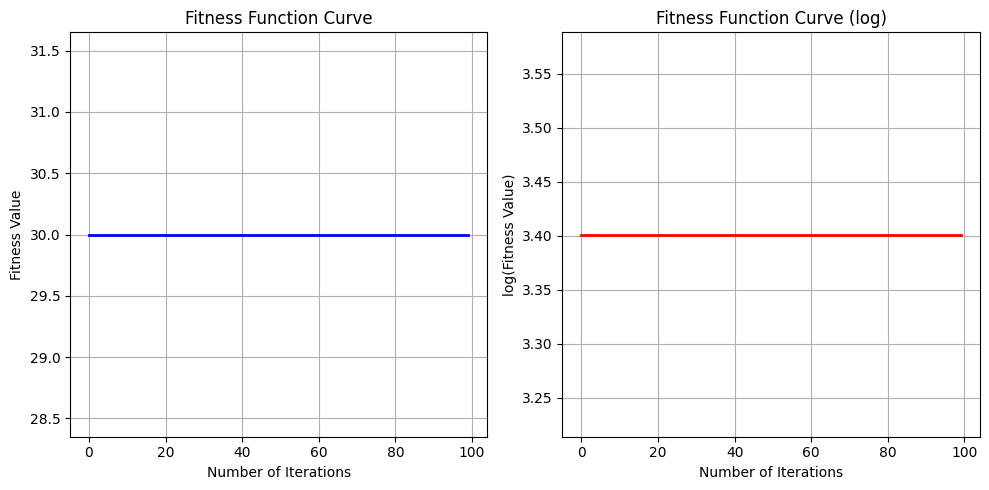

2025-07-27 16:51:45.289 | SUCCESS  | __main__:plot_map_with_best_path:43 - PSO算法迭代完成，共找到 101 个最优路径点（不包含起点和终点）


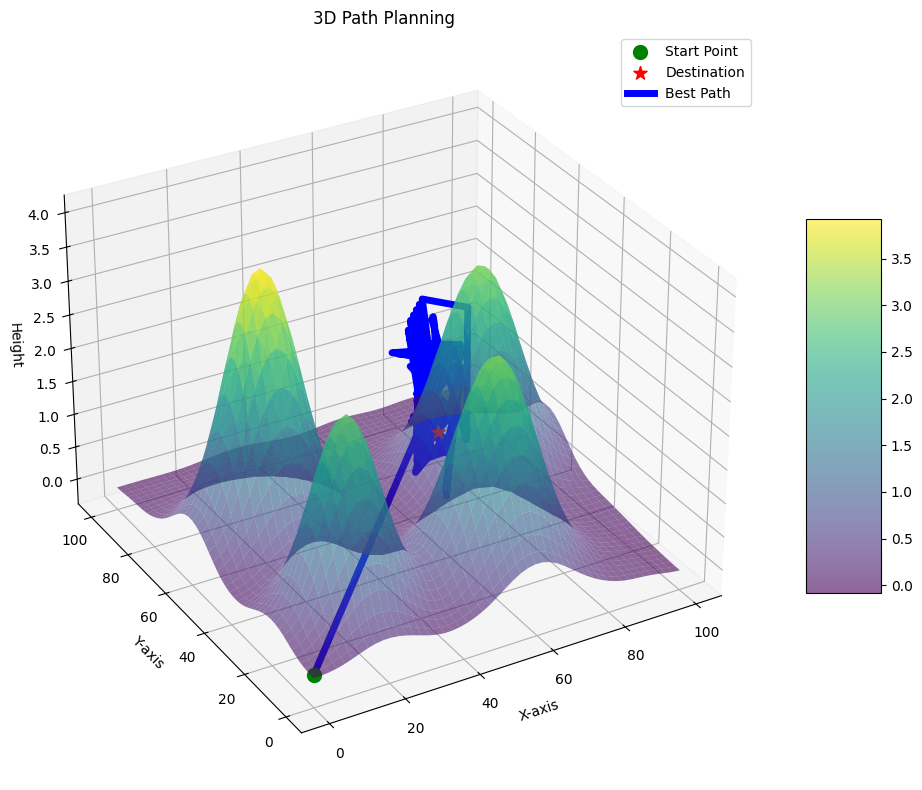

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
from scipy.spatial import KDTree

from pypso.core import AlgorithmArguments, PyPSO, ProblemType
from pypso.util import terrain, plot

# 定义模拟山峰的参数
PEAKS = [
    # center_x, center_y, amplitude, width
    (20, 20, 6, 6),
    (20, 60, 7, 7),
    (60, 20, 5, 8),
    (80, 60, 5, 8),
]

# 定义路径起点和终点坐标
START_POINT = (0.0, 0.0, 0.1)
DESTINATION = (80.0, 80.0, 0.1)


class PathPlanning3D:

    def __init__(self, pso_args: AlgorithmArguments):
        # 生成坐标网格
        x = np.linspace(pso_args.position_bounds_min[0], pso_args.position_bounds_max[0])
        y = np.linspace(pso_args.position_bounds_min[1], pso_args.position_bounds_max[1])
        self.x_grid, self.y_grid = np.meshgrid(x, y)
        self.z_grid = terrain.generate_simulated_mountain_peaks(self.x_grid, self.y_grid, PEAKS)

        # 初始化最优路径点
        self.best_path_points: list[tuple[float, float, float]] = [START_POINT]
        # 初始化最优路径成本
        self.best_path_costs: np.ndarray = np.zeros((pso_args.num_particles, pso_args.num_dimensions))

    def plot_map_with_best_path(self) -> None:
        """
        绘制地形和最优路径
        """
        # 在最优路径点中追加终点
        self.best_path_points.append(DESTINATION)
        logger.success(f"PSO算法迭代完成，共找到 {len(self.best_path_points) - 2} 个最优路径点（不包含起点和终点）")

        # 绘制地形
        figure = plt.figure(figsize=(10, 8))
        ax = figure.add_subplot(111, projection="3d")
        surface = ax.plot_surface(self.x_grid, self.y_grid, self.z_grid, cmap="viridis", alpha=0.6)
        figure.colorbar(surface, shrink=0.5, aspect=5)

        # 标记起点和终点
        start_x, start_y, start_z = START_POINT[0], START_POINT[1], START_POINT[2]
        destination_x, destination_y, destination_z = DESTINATION[0], DESTINATION[1], DESTINATION[2]
        ax.scatter(start_x, start_y, start_z, c='green', s=100, marker='o', label='Start Point')
        ax.scatter(destination_x, destination_y, destination_z, c='red', s=100, marker='*', label='Destination')

        # 绘制路径
        np_best_path_points = np.array(self.best_path_points)
        path_x, path_y, path_z = np_best_path_points[:, 0], np_best_path_points[:, 1], np_best_path_points[:, 2]
        ax.plot(path_x, path_y, path_z, 'b-', linewidth=5, label='Best Path')

        # 设置坐标轴信息，elev参数控制仰角，azim参数控制方位角
        ax.view_init(elev=30, azim=240)
        ax.set_title("3D Path Planning")
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_zlabel("Height")
        ax.legend()

        plt.tight_layout()
        plt.show()

    def compute_path_cost(self, positions: np.ndarray) -> np.ndarray:
        """
        适应度函数：计算路径成本

        Args:
            positions (np.ndarray): 所有粒子的位置向量，形状为 (num_particles, num_dimensions)

        Returns:
            路径成本大小，数据格式为 np.ndarray，形状为 (n, 1)
        """
        # PSO算法每迭代一次，就会产生一个当前最优路径点，在初始化时，它是起点，往后每次取最后一个最优路径点
        current_best_point = self.best_path_points[-1]

        # 基于 KNN 算法查找距离当前最优路径点最近的 K 个邻接点
        num_expected_neighbors = positions.shape[0]  # 期望找到的邻接点数量
        distances, indices = KDTree(positions).query(current_best_point, k=num_expected_neighbors)
        neighbors = positions[indices[1:]]  # 邻接点结果包含当前点自身，需排除
        logger.debug(f"当前最优路径点：{current_best_point}，找到的邻接点：{neighbors}")

        # 挑选目标邻接点
        expected_neighbors = []
        for neighbor in neighbors:
            is_expected_neighbor = True

            # 碰撞惩罚
            if terrain.is_collision_detected(neighbor, self.x_grid, self.y_grid, self.z_grid):
                logger.warning(f"邻接点 {neighbor} 会与地形发生碰撞，跳过并驱逐该点")
                self.best_path_costs += 5
                is_expected_neighbor = False

            # 高度惩罚
            allowed_max_height = np.max(self.z_grid)
            if neighbor[2] > allowed_max_height:
                logger.warning(f"邻接点 {neighbor} 高度超过限定阈值 {allowed_max_height}，跳过并驱逐该点")
                self.best_path_costs += 1
                is_expected_neighbor = False

            if is_expected_neighbor:
                expected_neighbors.append(neighbor)

        # 如果没有找到符合预期的邻接点，则返回一个无穷大值，表示当前路径点不可行
        if len(expected_neighbors) == 0:
            logger.warning("本次迭代没有找到符合预期的邻接点")
            self.best_path_costs += np.inf
            return np.sum(self.best_path_costs, axis=1)

        # 这里还是使用 KNN 算法查找目标邻接点中距离终点最近的点，k=1 表示只查找最近的那个点，把这个点作为当前最优路径点的下一个点
        distance_to_destination, i = KDTree(expected_neighbors).query(DESTINATION, k=1)
        mvp_x, mvp_y, mvp_z = expected_neighbors[i][0], expected_neighbors[i][1], expected_neighbors[i][2]
        self.best_path_points.append((mvp_x.item(), mvp_y.item(), mvp_z.item()))
        logger.debug(f"下一个最优路径点：({mvp_x}, {mvp_y}, {mvp_z})")

        return np.sum(self.best_path_costs, axis=1)


if __name__ == "__main__":
    # 初始化PSO算法参数
    pso_arguments = AlgorithmArguments(
        num_particles=100,
        num_dimensions=3,
        max_iterations=100,
        position_bounds_min=(0, 0, 0),
        position_bounds_max=(100, 100, 2),
        velocity_bound_max=1,
        inertia_weight_max=2,
        inertia_weight_min=0.5,
        cognitive_coefficient=0.5,
        social_coefficient=0.5
    )

    # 初始化待优化的路径规划问题
    path_planning_3d = PathPlanning3D(pso_arguments)

    # 初始化PSO优化器
    pso_optimizer = PyPSO(
        args=pso_arguments,
        objective_function=path_planning_3d.compute_path_cost
    )

    # 执行算法迭代
    best_fitness_values = pso_optimizer.start_iterating(
        problem_type=ProblemType.MINIMIZATION,
        dynamic_check_convergence=False
    )

    # 绘制适应度曲线
    plot.plot_fitness_curve(best_fitness_values)

    # 绘制最优路径
    path_planning_3d.plot_map_with_best_path()
